# Prophet baseline

Facebook released prophet 2 years ago and managed to create a better user experience, with easy customizability and performace boost, both in excecution time and in accuracy. The library is based on Stan, a state-of-the-art statistical modeling and computation platform.

In [1]:
import numpy as np
import pandas as pd  
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [19]:
# Load clean
data = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
data.request_date = pd.to_datetime(raw_pd.request_date)
# ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
# ts_df = pd.DataFrame(ts)
data

request_date  trip_counts
0    2015-09-01 00:00:00      705.000
1    2015-09-01 01:00:00      476.000
2    2015-09-01 02:00:00      489.000
3    2015-09-01 03:00:00      559.000
4    2015-09-01 04:00:00      353.000
...                  ...          ...
2900 2015-12-30 20:00:00      532.000
2901 2015-12-30 21:00:00      587.000
2902 2015-12-30 22:00:00      703.000
2903 2015-12-30 23:00:00     1171.000
2904 2015-12-31 00:00:00       20.424

[2905 rows x 2 columns]

In [22]:
# Required by prophet
fb_ts = data
fb_ts['ds'] = data.request_date.copy()
fb_ts['y'] = data.trip_counts.copy()


In [23]:
from fbprophet import Prophet

In [9]:
m = Prophet()
m.fit(fb_ts)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=30)
future.tail()

ds
2930 2016-01-26
2931 2016-01-27
2932 2016-01-28
2933 2016-01-29
2934 2016-01-30

In [11]:
forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2930 2016-01-26  1741.880530  1445.696456  3301.169751  1702.809376   
2931 2016-01-27  1758.070189  1532.971578  3433.270969  1717.290776   
2932 2016-01-28  1774.259847  1562.232662  3503.002135  1730.902219   
2933 2016-01-29  1790.449506  1659.487580  3626.055691  1745.219313   
2934 2016-01-30  1806.639165  1889.287371  3890.100561  1758.685508   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2930  1776.897965      643.407513            643.407513            643.407513   
2931  1795.549997      721.000414            721.000414            721.000414   
2932  1812.981123      769.843438            769.843438            769.843438   
2933  1831.793991      885.157676            885.157676            885.157676   
2934  1850.258014     1065.688175           1065.688175           1065.688175   

           daily  daily_lower  daily_upper      weekly  weekly_lower  \
2930  784.020704   784.020704   784.020704 -140.613191   -140.613191   
2931  784.020704   784.020704   784.020704  -63.020290    -63.020290   
2932  784.020704   784.020704   784.020704  -14.177266    -14.177266   
2933  784.020704   784.020704   784.020704  101.136972    101.136972   
2934  784.020704   784.020704   784.020704  281.667471    281.667471   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
2930   -140.613191                   0.0                         0.0   
2931    -63.020290                   0.0                         0.0   
2932    -14.177266                   0.0                         0.0   
2933    101.136972                   0.0                         0.0   
2934    281.667471                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2930                         0.0  2385.288043  
2931                         0.0  2479.070603  
2932                         0.0  2544.103286  
2933                         0.0  2675.607182  
2934                         0.0  2872.327340

<IPython.core.display.Javascript object>


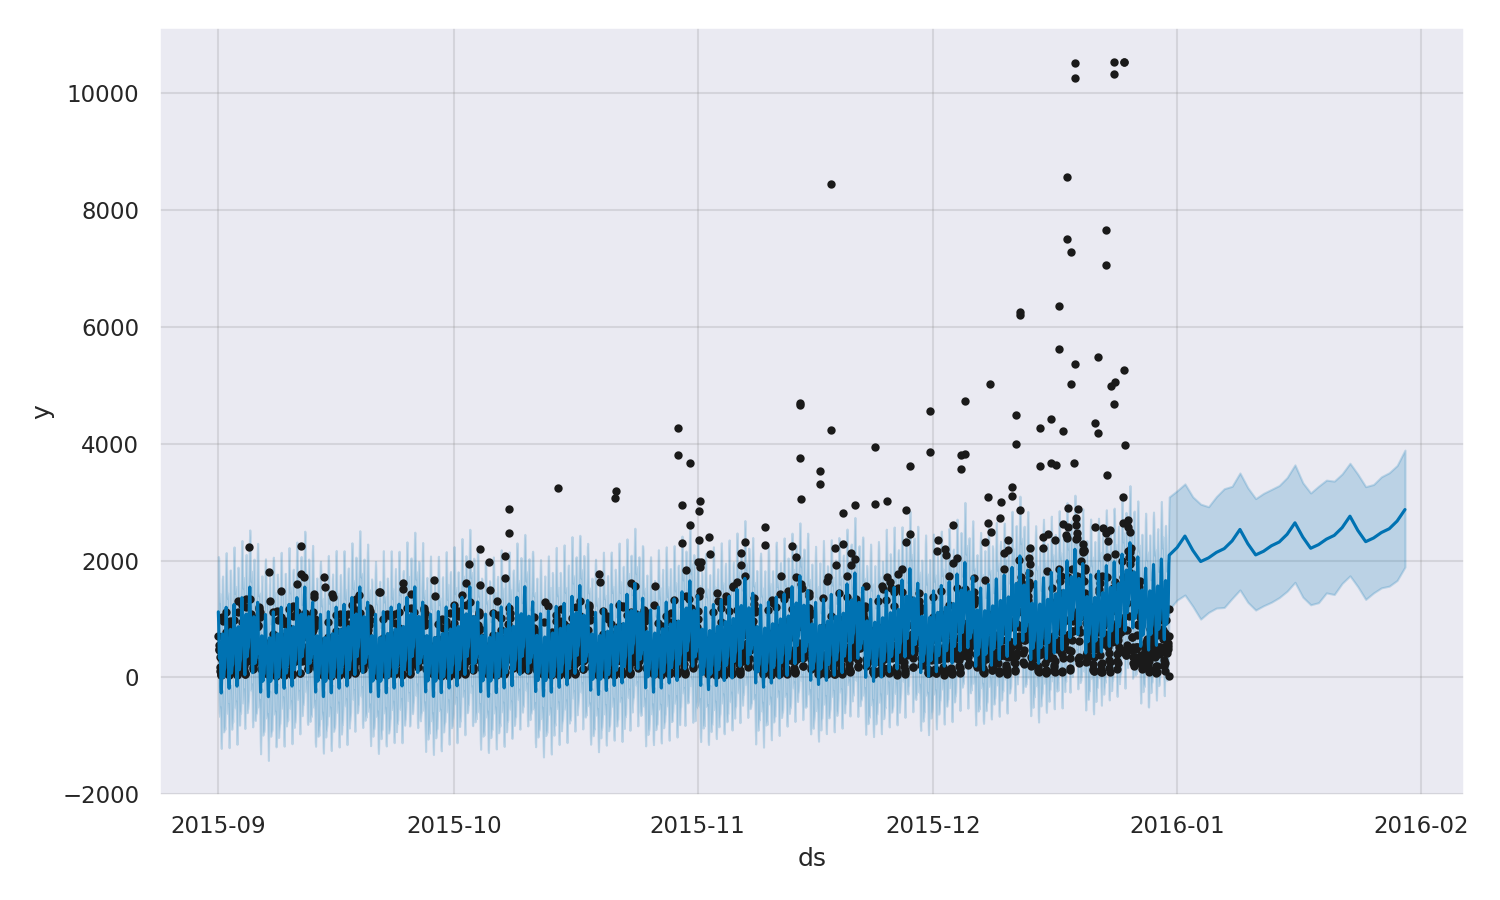

In [12]:
m.plot(forecast)
plt.show()

## Components

The process of decomposing the trend and seasonality is depicted below, and we can see that the trend is not dropping. We will improve this in a later iteration.

<IPython.core.display.Javascript object>


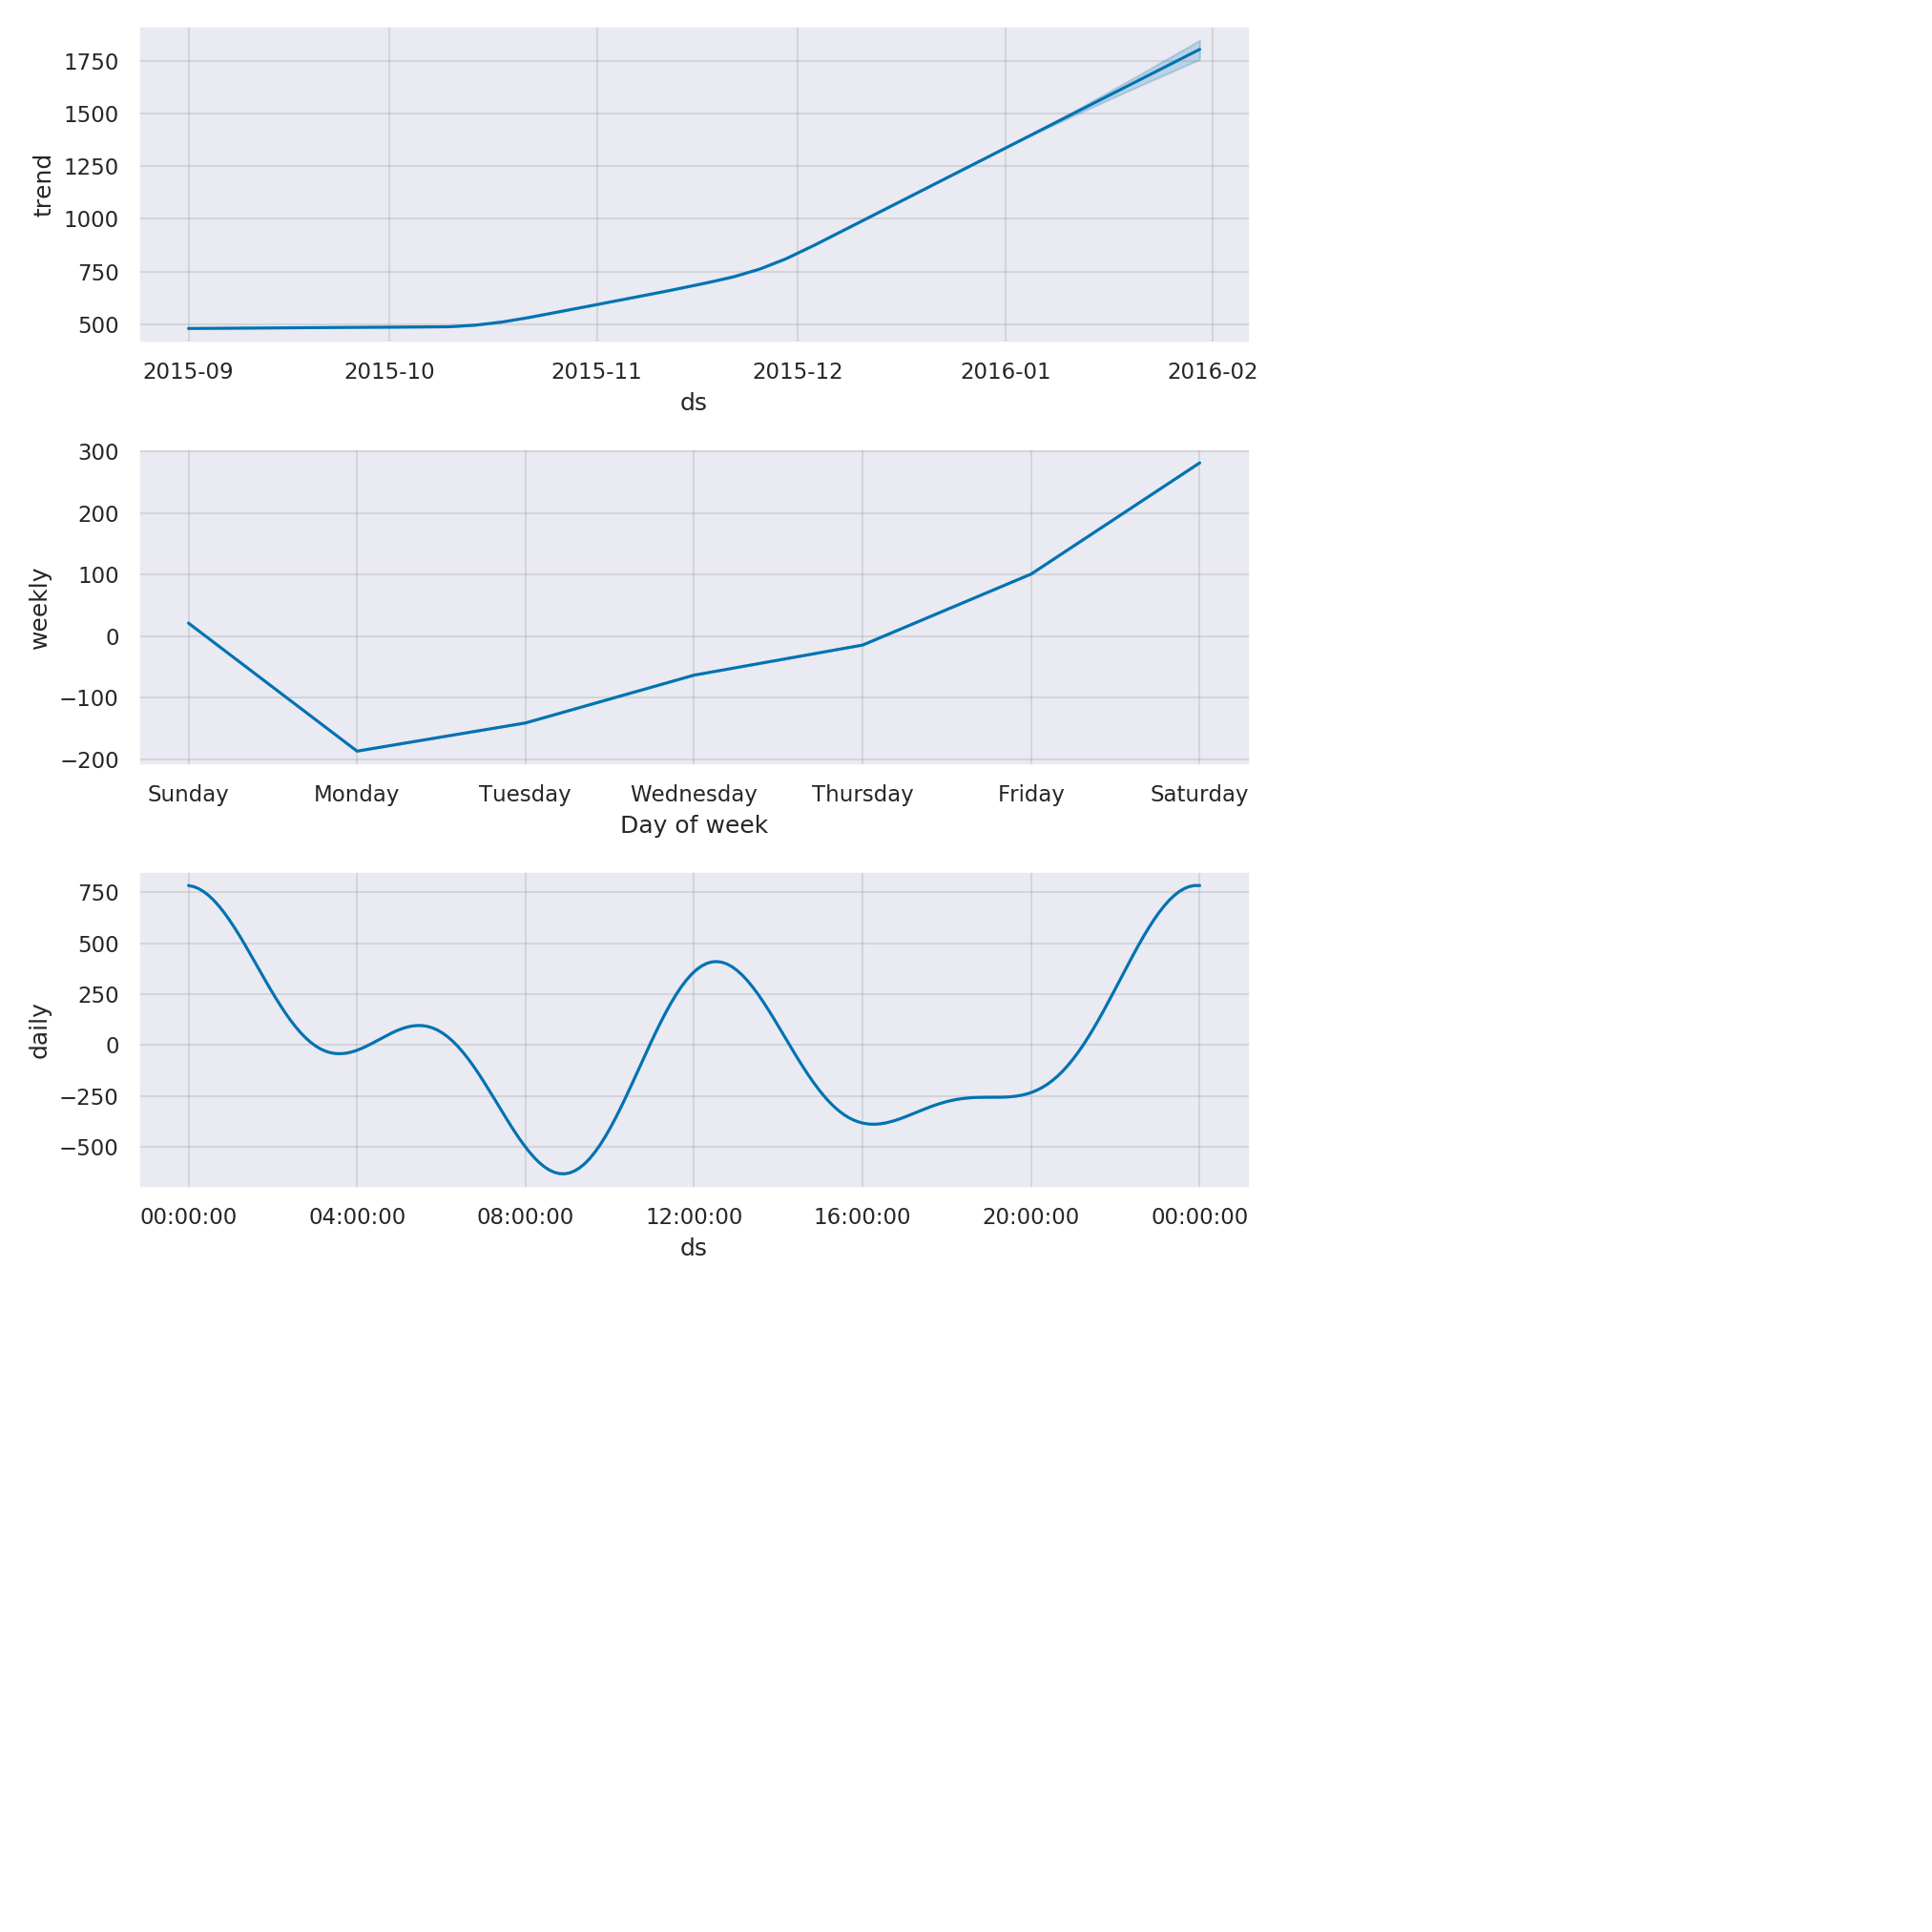

In [13]:
m.plot_components(forecast)
plt.show()

## Closer examination with Plotly

A more interactive view is provided with a plotly diagram, for examination and qualitive assessment.

In [14]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Cross validation: 4 forecasts after an initial period of 2months

In [15]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='60 days', period='15 days', horizon = '5 days')
df_cv.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-11-11 00:00:00 and 2015-12-26 00:00:00


ds        yhat  yhat_lower   yhat_upper      y     cutoff
0 2015-11-11 01:00:00  940.612334  474.804039  1403.647948  643.0 2015-11-11
1 2015-11-11 02:00:00  789.404721  341.955832  1282.474871  719.0 2015-11-11
2 2015-11-11 03:00:00  670.689974  213.255759  1126.058181  682.0 2015-11-11
3 2015-11-11 04:00:00  645.870381  208.599266  1127.967016  417.0 2015-11-11
4 2015-11-11 05:00:00  656.860523  210.195932  1124.997487  289.0 2015-11-11

In [16]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse         mae      mape  coverage
0 12:00:00  6.132720e+05   783.116858  529.616831  1.911741  0.750000
1 13:00:00  9.255552e+05   962.057802  640.220991  2.099655  0.687500
2 14:00:00  9.971658e+05   998.581898  683.964446  2.265032  0.666667
3 15:00:00  1.037076e+06  1018.369427  716.595928  2.368707  0.645833
4 16:00:00  1.066327e+06  1032.631290  736.507291  2.446728  0.625000

In [17]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

<IPython.core.display.Javascript object>


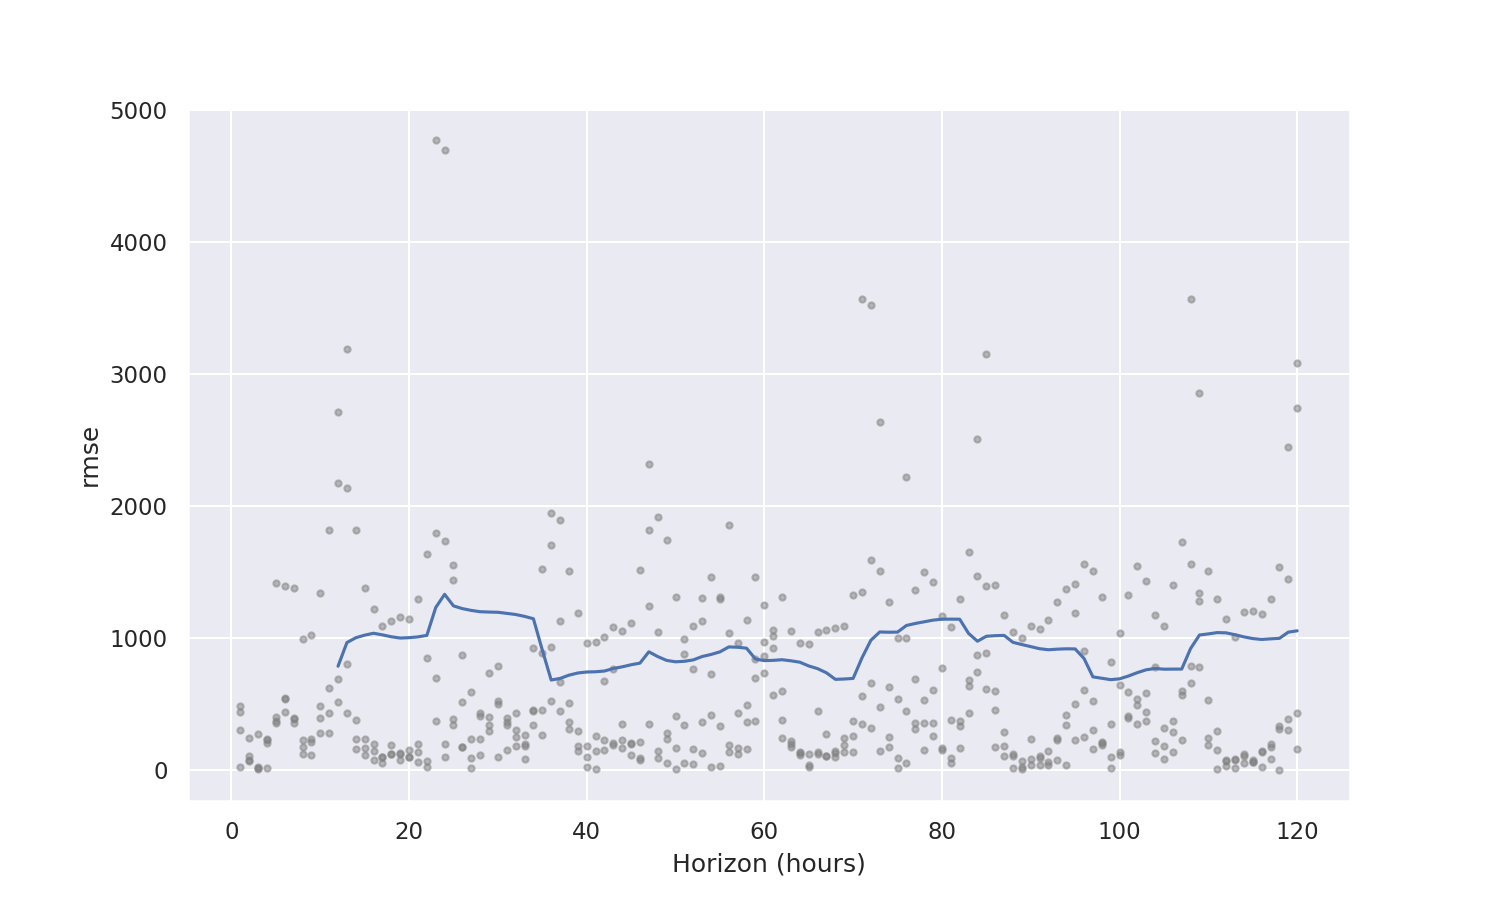

In [18]:
fig.show()

# Conclusion

Facebook prophet has out of the box provided a very good result, both in showing a notion of trend and an understanding of seasonality. Moreover the streamlined interface and toolchain create a superb experience. We will see if we can improve the results in a following notebook.